In [1]:
import pandas as pd
from datetime import datetime, date
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.cluster import KMeans
#%pip install pyarrow

tx = pd.read_parquet("C:/Users/Fernanda/Documents/Python Scripts/DS4A/transacciones_movii.parquet", engine='pyarrow')

In [2]:
tx['year'] = pd.DatetimeIndex(tx['fecha_transaccion']).year
tx['month'] = pd.DatetimeIndex(tx['fecha_transaccion']).month
tx = tx.drop_duplicates()
tx.head(5)

,id,fecha_transaccion,nombre_producto,codigo_transaccion,tipo_deposito,producto,sub_producto,movilizado,trx_activo,nro_transaccion,usr_id,year,month
0,133,2020-11-21,ENVIO TRANSFERENCIA ACH,2301,SIMPLE,CASH OUT,TRANSFIYA,160000.0,0.0,1.0,3249216,2020,11
1,181,2020-08-22,RECARGAR CELULAR,2202,SIMPLE,TOP UP,TOP UP,10000.0,0.0,1.0,447637,2020,8
2,277,2021-12-18,PAGO CON TARJETA,6802,SIMPLE,DEBIT CARD,TARJETA,24080.0,0.0,1.0,645887,2021,12
3,341,2020-07-01,RETIRO CUENTA VIA BALOTO,2702,SIMPLE,CASH OUT,BALOTO,160000.0,0.0,1.0,67194,2020,7
4,389,2021-01-27,RETIRO CASHOUT,2206,SIMPLE,CASH OUT,EXITO,100000.0,0.0,1.0,569810,2021,1


As part of the clustering model we don't want to only use the numerical values, but we want to take advantage of trasanction information we have such as the product or subproduct the clients are using on their transactions as the *Handbook for Fraud Detection* suggest. Initially, we though about taking the top 3 product or subproducts the users use in their transactions, but just to check, lets see how many of the users have up to 3 products, and how many may have more.

In [ ]:
tx_pro_usr = tx.groupby(['usr_id', 'producto']).size()
tx_pro_usr = tx_pro_usr[tx_pro_usr > 0].groupby(['usr_id']).size().reset_index()
tx_pro_usr.rename(columns = {0:'cantidad'}, inplace = True)
tx_pro_usr = tx_pro_usr.groupby(['cantidad']).size().reset_index()
tx_pro_usr['CUMSUM_C'] = tx_pro_usr[0].cumsum()
tx_pro_usr['cum_perc'] = 100*tx_pro_usr['CUMSUM_C']/tx_pro_usr[0].sum()
tx_pro_usr

When it comes to products we can say most of the customers trasactions can be described by 3 top products since over 94% of the population uses only 3 products or less. The porcentual change from 3 to 4 products decreases significantly so we can think of 3 as a good numbers to start. Now lets do the same calculation by subproduct.

In [ ]:
tx_pro_usr = tx.groupby(['usr_id', 'sub_producto']).size()
tx_pro_usr = tx_pro_usr[tx_pro_usr > 0].groupby(['usr_id']).size().reset_index()
tx_pro_usr.rename(columns = {0:'cantidad'}, inplace = True)
tx_pro_usr = tx_pro_usr.groupby(['cantidad']).size().reset_index()
tx_pro_usr['CUMSUM_C'] = tx_pro_usr[0].cumsum()
tx_pro_usr['cum_perc'] = 100*tx_pro_usr['CUMSUM_C']/tx_pro_usr[0].sum()
tx_pro_usr

By subproduct we can think of the 4 main subproducts the customer use as a good starting number. We will try to use the top 3 products and then the top 4 subproducts and see the differences and which may be better.

In [ ]:
tx_pro_usr = tx.groupby(['usr_id', 'nombre_producto']).size()
tx_pro_usr = tx_pro_usr[tx_pro_usr > 0].groupby(['usr_id']).size().reset_index()
tx_pro_usr.rename(columns = {0:'cantidad'}, inplace = True)
tx_pro_usr = tx_pro_usr.groupby(['cantidad']).size().reset_index()
tx_pro_usr['CUMSUM_C'] = tx_pro_usr[0].cumsum()
tx_pro_usr['cum_perc'] = 100*tx_pro_usr['CUMSUM_C']/tx_pro_usr[0].sum()
tx_pro_usr

In [3]:
## Calculate top 3 products of each custumer to then use one hot coding to change from categorical to numerical variable.

top_3 = tx.groupby(['usr_id', 'producto'])['movilizado'].sum().reset_index()

In [4]:
top_3 = top_3[top_3['movilizado'] != 0].sort_values(by = (['usr_id', 'movilizado']), ascending=False)
top_3 = top_3.groupby('usr_id').head(3)
top_3.head(10)

,usr_id,producto,movilizado
17873334,3328215,CASH OUT,270000.000000
17873314,3328208,CB,11910.000000
17873292,3328200,CASH OUT,265000.000000
17873301,3328200,P2P,160000.000000
17873296,3328200,DEBIT CARD,64377.539062
17873275,3328199,DEBIT CARD,40000.000000
17873250,3328198,CASH OUT,240000.000000
17873267,3328198,WELLFARE,240000.000000
17873266,3328198,TOP UP,9000.000000
17873246,3328197,WELLFARE,164000.000000


In [5]:
top_3['count'] = top_3.groupby('usr_id').cumcount()+1
top_3 = top_3.drop('movilizado', axis=1)
top_3.head(10)

,usr_id,producto,count
17873334,3328215,CASH OUT,1
17873314,3328208,CB,1
17873292,3328200,CASH OUT,1
17873301,3328200,P2P,2
17873296,3328200,DEBIT CARD,3
17873275,3328199,DEBIT CARD,1
17873250,3328198,CASH OUT,1
17873267,3328198,WELLFARE,2
17873266,3328198,TOP UP,3
17873246,3328197,WELLFARE,1


In [6]:
top_3 = top_3.pivot(index=['usr_id'], columns='count', values='producto')
top_3 = top_3.rename(columns={1:'Top_1', 2:'Top_2', 3:'Top_3'})
top_3.head(10)

count,Top_1,Top_2,Top_3
usr_id,,,
4,WELLFARE,P2P,NaN
6,CASH IN,CB,INCOMM
9,CB,NaN,NaN
12,P2P,NaN,NaN
16,CASH OUT,NaN,NaN
17,CASH IN,DEBIT CARD,NaN
25,CASH OUT,WELLFARE,NaN
38,CASH OUT,INCOMM,NaN
39,CASH OUT,NaN,NaN


Now that we have the code for the products let's add some of the numerical variables we want to have in the model. Since we are trying to group the users by their transactions behaviour we have two measures that will be helpfull, how much money they use on them and how often they happen, this can be represented by **average monthly trasactions (Q)** and **average monthly amount ($)**.

In [11]:
avg_usr = tx.groupby(['usr_id', 'year', 'month'])['movilizado'].sum().reset_index()
avg_usr = avg_usr.groupby(['usr_id'])['movilizado'].mean().reset_index()
avg_usr = avg_usr.rename(columns = {'movilizado':'avg_m_amount'})

x = tx.groupby(['usr_id', 'year', 'month'])['movilizado'].count().reset_index()
x = x.groupby(['usr_id'])['movilizado'].mean().reset_index()
x = x.rename(columns = {'movilizado':'avg_m_tx'})

avg_usr = pd.concat([avg_usr, x['avg_m_tx']], axis=1)
avg_usr = avg_usr.merge(top_3, on='usr_id', how='left')

avg_usr.head(10)

,usr_id,avg_m_amount,avg_m_tx,Top_1,Top_2,Top_3
0,4,266666.656250,1.000000,WELLFARE,P2P,NaN
1,6,51805.882812,1.588235,CASH IN,CB,INCOMM
2,9,82120.000000,1.000000,CB,NaN,NaN
3,12,30000.000000,1.000000,P2P,NaN,NaN
4,16,275000.000000,1.000000,CASH OUT,NaN,NaN
5,17,114848.796875,1.800000,CASH IN,DEBIT CARD,NaN
6,25,236333.328125,1.333333,CASH OUT,WELLFARE,NaN
7,38,100000.000000,1.000000,CASH OUT,INCOMM,NaN
8,39,-160000.000000,1.000000,CASH OUT,NaN,NaN
9,40,191200.000000,1.200000,CASH OUT,WELLFARE,TOP UP


In [8]:
#Set base for age and age group
df = pd.read_csv("C:/Users/Fernanda/Documents/Python Scripts/DS4A/users.csv", sep=';')
df['dob'] = pd.to_datetime(df['dob'], errors = 'coerce', format = '%Y-%m-%d')
df['age'] = (2022 - df['dob'].dt.year)

q1 = df.age.quantile([0.25]).reset_index().age
q3 = df.age.quantile([0.75]).reset_index().age

low_bound = q1 - 1.5 * (q3 - q1)
up_bound = q3 + 1.5 * (q3 - q1)

df['is_valid1'] = df.age < float(up_bound)
df['is_valid2'] = df.age > 10
df['is_valid'] = df['is_valid1'] & df['is_valid2']
df = df.drop(['is_valid1', 'is_valid2'], axis=1)

df_valid = df[df['is_valid'] == True].copy()

def age_group(age):
    if age <= 15:
        ag = "0-15"
    elif age <= 20:
        ag = "16-20"
    elif age <= 25:
        ag = "21-25"
    elif age <= 30:
        ag = "26-30"
    elif age <= 35:
        ag = "31-35"
    elif age <= 40:
        ag = "36-40"
    elif age <= 45:
        ag = "41-45"
    elif age <= 50:
        ag = "46-50"
    elif age <= 55:
        ag = "51-55"
    elif age <= 60:
        ag = "56-60"
    elif age <= 65:
        ag = "61-65"
    else: ag = "66-70"
    return ag

df_valid['age_group'] = df_valid.apply(lambda x: age_group(x['age']), axis=1)

In [12]:
df_valid = df_valid.rename(columns={'id':'usr_id'})
avg_usr = avg_usr.merge(df_valid[['usr_id', 'age']], on='usr_id', how='left')
avg_usr = avg_usr[avg_usr['age'].notna()]
avg_usr.head(10)

,usr_id,avg_m_amount,avg_m_tx,Top_1,Top_2,Top_3,age
0,4,266666.656250,1.000000,WELLFARE,P2P,NaN,29.0
1,6,51805.882812,1.588235,CASH IN,CB,INCOMM,25.0
2,9,82120.000000,1.000000,CB,NaN,NaN,30.0
3,12,30000.000000,1.000000,P2P,NaN,NaN,36.0
4,16,275000.000000,1.000000,CASH OUT,NaN,NaN,48.0
5,17,114848.796875,1.800000,CASH IN,DEBIT CARD,NaN,40.0
6,25,236333.328125,1.333333,CASH OUT,WELLFARE,NaN,35.0
7,38,100000.000000,1.000000,CASH OUT,INCOMM,NaN,47.0
8,39,-160000.000000,1.000000,CASH OUT,NaN,NaN,42.0
9,40,191200.000000,1.200000,CASH OUT,WELLFARE,TOP UP,49.0


Now that we have the data ready let's start with an scatterplot to see the relation of the users between the transactions done and its amounts monthly.

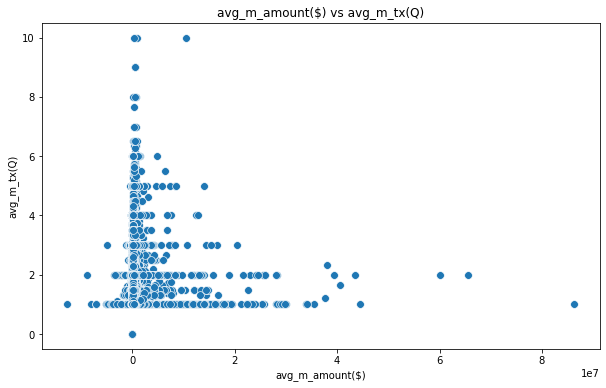

In [13]:
#Scatterplot of the data
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'avg_m_amount', y = 'avg_m_tx',  data = avg_usr , s = 60 )
plt.xlabel('avg_m_amount($)')
plt.ylabel('avg_m_tx(Q)') 
plt.title('avg_m_amount($) vs avg_m_tx(Q)')
plt.show()

First let's try to cluster these two variables.

In [18]:
cluster1 = KMeans()
cluster1.fit(avg_usr[['avg_m_amount', 'avg_m_tx']])
avg_usr['Cluster_avgs'] = cluster1.labels_
avg_usr.head(10)

,usr_id,avg_m_amount,avg_m_tx,Top_1,Top_2,Top_3,age,Cluster avgs
0,4,266666.656250,1.000000,WELLFARE,P2P,NaN,29.0,7
1,6,51805.882812,1.588235,CASH IN,CB,INCOMM,25.0,0
2,9,82120.000000,1.000000,CB,NaN,NaN,30.0,0
3,12,30000.000000,1.000000,P2P,NaN,NaN,36.0,0
4,16,275000.000000,1.000000,CASH OUT,NaN,NaN,48.0,7
5,17,114848.796875,1.800000,CASH IN,DEBIT CARD,NaN,40.0,7
6,25,236333.328125,1.333333,CASH OUT,WELLFARE,NaN,35.0,7
7,38,100000.000000,1.000000,CASH OUT,INCOMM,NaN,47.0,0
8,39,-160000.000000,1.000000,CASH OUT,NaN,NaN,42.0,0
9,40,191200.000000,1.200000,CASH OUT,WELLFARE,TOP UP,49.0,7


In [20]:
avg_usr.groupby('Cluster_avgs').size()

Cluster avgs
0    427425
1       183
2     89564
3       286
4        39
5      3746
6         3
7    308026
dtype: int64

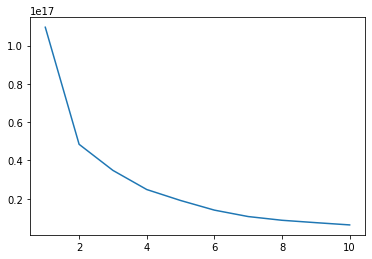

In [21]:
inertia_scores = []
for i in range(1, 11):
    Kmeans = KMeans(n_clusters=i)
    Kmeans.fit(avg_usr[['avg_m_amount', 'avg_m_tx']])
    inertia_scores.append(Kmeans.inertia_)

plt.plot(range(1,11), inertia_scores)

<AxesSubplot:xlabel='avg_m_amount', ylabel='avg_m_tx'>

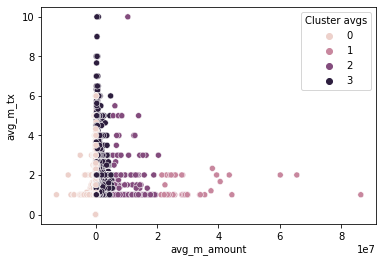

In [23]:
cluster1 = KMeans(n_clusters = 4)
cluster1.fit(avg_usr[['avg_m_amount', 'avg_m_tx']])
avg_usr['Cluster_avgs'] = cluster1.labels_

sns.scatterplot(data = avg_usr, x = 'avg_m_amount', y = 'avg_m_tx', hue = 'Cluster_avgs')

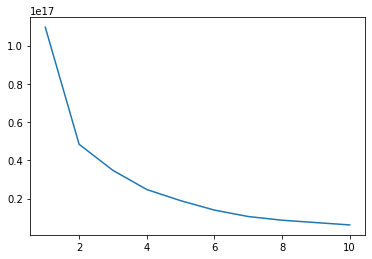

In [24]:
cluster2 = KMeans()
cluster2.fit(avg_usr[['avg_m_amount', 'avg_m_tx', 'age']])

inertia_scores2 = []
for i in range(1, 11):
    Kmeans2 = KMeans(n_clusters=i)
    Kmeans2.fit(avg_usr[['avg_m_amount', 'avg_m_tx', 'age']])
    inertia_scores2.append(Kmeans2.inertia_)

plt.plot(range(1,11), inertia_scores2)

<AxesSubplot:xlabel='avg_m_amount', ylabel='avg_m_tx'>

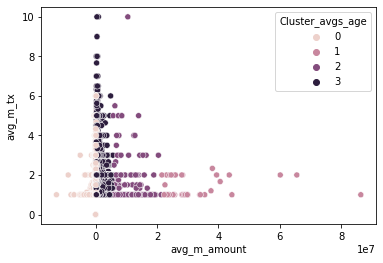

In [56]:
cluster2 = KMeans(n_clusters = 4)
cluster2.fit(avg_usr[['avg_m_amount', 'avg_m_tx', 'age']])
avg_usr['Cluster_avgs_age'] = cluster2.labels_

#fig = plt.figure(figsize=(12, 12))
#ax = fig.add_subplot(projection='3d')

#ax.scatter(data = avg_usr, x = 'avg_m_amount', y = 'avg_m_tx', z = 'age', hue = 'Cluster_avgs_age')
#plt.show()

sns.scatterplot(data = avg_usr, x = 'avg_m_amount', y = 'avg_m_tx', hue = 'Cluster_avgs_age')

In [86]:
from sklearn import preprocessing
avg_usr_norm = avg_usr.copy()
scaler = preprocessing.MinMaxScaler()
avg_usr_norm[['age']] = scaler.fit_transform(avg_usr_norm[['age']])

avg_usr_norm = avg_usr_norm.drop(['Cluster avgs', 'Cluster_avgs_age'], axis = 1)

In [108]:
avg_usr_norm_x = avg_usr_norm.drop(['usr_id'], axis = 1)
avg_usr_norm_y = avg_usr_norm['usr_id']

avg_usr_norm_x['Top_1'] = avg_usr_norm_x['Top_1'].astype('object')
avg_usr_norm_x['Top_2'] = avg_usr_norm_x['Top_2'].astype('object')
avg_usr_norm_x['Top_3'] = avg_usr_norm_x['Top_3'].astype('object')
avg_usr_norm_x['Top_1'] = avg_usr_norm_x['Top_1'].fillna('Not defined')
avg_usr_norm_x['Top_2'] = avg_usr_norm_x['Top_2'].fillna('Not defined')
avg_usr_norm_x['Top_3'] = avg_usr_norm_x['Top_3'].fillna('Not defined')

for col in ['Top_1', 'Top_2', 'Top_3']:
    avg_usr_norm_x[col] = avg_usr_norm_x[col].astype('category')

In [ ]:
from kmodes.kprototypes import KPrototypes
kproto = KPrototypes(n_clusters=4, init='Cao')
clusters = kproto.fit_predict(avg_usr_norm_x, categorical=[2, 3, 4])
#join data with labels 
labels = pd.DataFrame(clusters)
labeledCustomers = pd.concat((avg_usr_norm_y, avg_usr_norm_x, labels),axis=1)
labeledCustomers = labeledCustomers.rename({0:'labels'},axis=1)

This model did not work, over 2 hours and it didn't finish calculating.

***One Hot Encoding Clustering***

In [47]:
top_3 = tx.groupby(['usr_id', 'producto'])['movilizado'].sum().reset_index()
top_3 = top_3[top_3['movilizado'] != 0]

In [54]:
prod_dummy = pd.get_dummies(top_3['producto'], prefix = 'producto')

dfg = pd.concat([top_3, prod_dummy], axis = 1)
dfg = dfg.drop(['producto', 'movilizado'], axis = 1)
dfg = dfg.groupby('usr_id').sum()

dfg = dfg.merge(avg_usr[['usr_id', 'avg_m_amount', 'avg_m_tx', 'age']], on='usr_id', how='left')
dfg = dfg[dfg['age'].notna()]

dfg.head(10)

,usr_id,producto_AJUSTE,producto_BONO,producto_CASH IN,producto_CASH OUT,producto_CB,producto_COMISION,producto_CRIPTO MONEDA,producto_DEBIT CARD,producto_GIRO F,...,producto_PAGO PRESTI,producto_PRESTI,producto_REMESAS INTERNACIONALES,producto_SEGURO,producto_TARJETA,producto_TOP UP,producto_WELLFARE,avg_m_amount,avg_m_tx,age
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,266666.656250,1.000000,29.0
1,6,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,51805.882812,1.588235,25.0
2,9,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,82120.000000,1.000000,30.0
3,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,30000.000000,1.000000,36.0
4,16,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,275000.000000,1.000000,48.0
5,17,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,114848.796875,1.800000,40.0
6,25,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,236333.328125,1.333333,35.0
7,38,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,100000.000000,1.000000,47.0
8,39,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,-160000.000000,1.000000,42.0
9,40,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,191200.000000,1.200000,49.0


****Gower Distance****

In [79]:
sample_n = dfg.sample(5000)

import gower

dist_matrix = gower.gower_matrix(sample_n)

In [80]:
from sklearn.cluster import DBSCAN

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.3, 
                        min_samples=2, 
                        metric="precomputed")

# Fitting the clustering algorithm
dbscan_cluster.fit(dist_matrix)

# Adding the results to a new column in the dataframe
sample_n["cluster"] = dbscan_cluster.labels_

Tried the Gover distance but the dataset it's way too big, I tried to use it with a sample but is only giving one cluster as result, so it's not working.

In [111]:
dfg_norm = dfg.copy()
scaler = preprocessing.MinMaxScaler()
dfg_norm[['age']] = scaler.fit_transform(dfg_norm[['age']])

dfg_norm_x = dfg_norm.drop(['usr_id'], axis = 1)
dfg_norm_y = dfg_norm['usr_id']

In [119]:
kmeans = KMeans(4)
clusters = kmeans.fit_predict(dfg_norm_x)
labels = pd.DataFrame(clusters)
labeledCustomers = pd.concat((dfg_norm_y, dfg_norm_x, labels),axis=1)
labeledCustomers = labeledCustomers.rename({0:'labels'},axis=1)

labeledCustomers.head(10)

,usr_id,producto_AJUSTE,producto_BONO,producto_CASH IN,producto_CASH OUT,producto_CB,producto_COMISION,producto_CRIPTO MONEDA,producto_DEBIT CARD,producto_GIRO F,...,producto_PRESTI,producto_REMESAS INTERNACIONALES,producto_SEGURO,producto_TARJETA,producto_TOP UP,producto_WELLFARE,avg_m_amount,avg_m_tx,age,labels
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,266666.656250,1.000000,0.305085,0.0
1,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,51805.882812,1.588235,0.237288,3.0
2,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,82120.000000,1.000000,0.322034,3.0
3,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,30000.000000,1.000000,0.423729,3.0
4,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,275000.000000,1.000000,0.627119,0.0
5,17.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,114848.796875,1.800000,0.491525,3.0
6,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,236333.328125,1.333333,0.406780,0.0
7,38.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100000.000000,1.000000,0.610169,3.0
8,39.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-160000.000000,1.000000,0.525424,3.0
9,40.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,191200.000000,1.200000,0.644068,3.0


<AxesSubplot:xlabel='avg_m_amount', ylabel='avg_m_tx'>

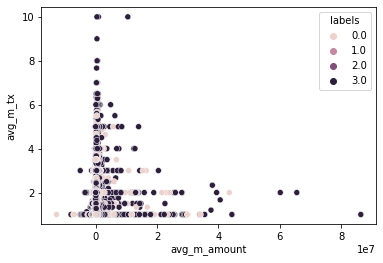

In [120]:
#labeledCustomers.groupby('labels').size()

sns.scatterplot(data = labeledCustomers, x = 'avg_m_amount', y = 'avg_m_tx', hue = 'labels')

In [121]:
labeledCustomers.groupby('labels').size()

labels
0.0    189241
1.0       284
2.0        40
3.0    619393
dtype: int64